In [44]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder
from interpolation import CensusData, BlockInterpolator, CentroidInterpolator, archive, interpolation
from xgboost import XGBClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import hdbscan

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get Data

In [2]:
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv")
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
filled_1850.dropna(subset = ["block_num"], inplace = True)

In [3]:
ward_col = "Ward_Num"
dwelling_col = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"

In [4]:
census_data = CensusData(filled_1850, ward_col=ward_col, dwelling_col=dwelling_col, block_col =  block_col, x_col = x_col, y_col = y_col)
census_data.census_records_with_seq()

## Block Number Prediction

In [5]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID", "sequence_order_enum", 'CENSUS_DWELLING_SEQ']
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID", "sequence_order_enum", 'CENSUS_DWELLING_SEQ'])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 80))])

In [6]:
interpolate_blocks = BlockInterpolator(census_data, 10, block_boost, all_cols)
train,test = interpolate_blocks.stratified_train_test(False)
interpolate_blocks.train_test_model(train, test)

In [7]:
print("Training Score:", interpolate_blocks.train_score)
print("Test Score:", interpolate_blocks.test_score)

Training Score: 0.9997232216994187
Test Score: 0.17117537313432835


In [23]:
# test_results = test.copy()
# test_results["predicted"] = interpolate_blocks.predict(test)
# display(interpolation.class_analysis(test_results, block_col))

##### Try smote to see if it can cope with the imbalanced classes

In [9]:
boost_model = XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 80)
interpolate_blocks.set_model(boost_model)

In [10]:
train_encoded, test_encoded, train_y, test_y = interpolate_blocks.target_encoder(train, test)
train_sampled_X, train_sampled_y = SMOTE().fit_resample(train_encoded, train_y)
interpolate_blocks.train_test_model(train_sampled_X, test_encoded, train_sampled_y, test_y)

In [11]:
print("Training Score:", interpolate_blocks.train_score)
print("Test Score:", interpolate_blocks.test_score)

Training Score: 0.996268656716418
Test Score: 0.17630597014925373


In [22]:
# test_results = test.copy()
# test_results["predicted"] = interpolate_blocks.predict(test_encoded)
# display(interpolation.class_analysis(test_results, block_col))

##### Smote and undersampling 

In [17]:
over = SMOTE()
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [18]:
train_sampled_X, train_sampled_y = pipeline.fit_resample(train_encoded, train_y)
interpolate_blocks.train_test_model(train_sampled_X, test_encoded, train_sampled_y, test_y)

In [19]:
print("Training Score:", interpolate_blocks.train_score)
print("Test Score:", interpolate_blocks.test_score)

Training Score: 0.9963251922207146
Test Score: 0.18190298507462688


In [21]:
# test_results = test.copy()
# test_results["predicted"] = interpolate_blocks.predict(test_encoded)
# display(interpolation.class_analysis(test_results, block_col))

This clearly didn't work well, and even attempts to deal with imbalanced classes didn't improve the situation much. Let's try the centroid approach.

## Centroids Prediction

The goal of this process is to add a level of geographic specificity to census records for which the linkage process produced no new information. Conceptually this process creates centroids for each block and then clusters them so that each record with a known address is labelled with a cluster based on its block number. The model is trained to predict cluster label on records with known addresses, and then used to predict the cluster of data with no address label. This way every single record will be assigned a centroid with a range of corresponding possible blocks

### RidgeClassifier versus XGboost

#### RidgeClassifier

In [24]:
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}
centroid_ridge = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID", "sequence_order_enum", 'CENSUS_DWELLING_SEQ'])),
                        ('classifier', RidgeClassifier())])

In [25]:
centroid_ridge_interpolator = CentroidInterpolator(census_data, 10, centroid_ridge, all_cols, AgglomerativeClustering(5), block_centroids)

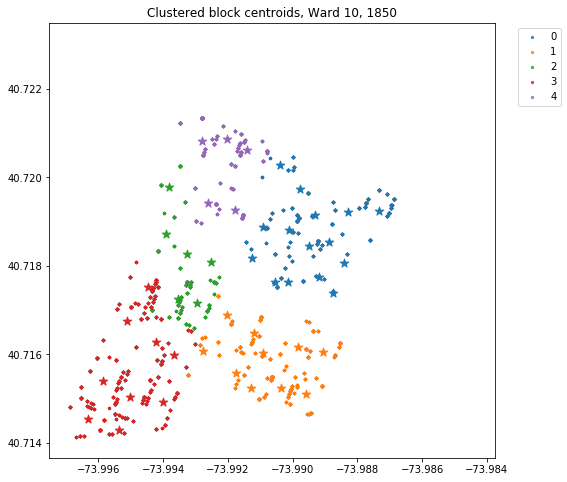

In [26]:
centroid_ridge_interpolator.apply_clustering()
centroid_ridge_interpolator.clustervis()

In [27]:
train,test = centroid_ridge_interpolator.stratified_train_test()
centroid_ridge_interpolator.train_test_model(train, test)

In [28]:
print("Training Score:", centroid_ridge_interpolator.train_score)
print("Test Score:", centroid_ridge_interpolator.test_score)

Training Score: 0.6074890452795113
Test Score: 0.41054921152800433


In [50]:
centroid_ridge_interpolator.model.named_steps["classifier"].coef_

array([[-0.30224587,  0.00949288, -0.02642158,  0.05435225,  0.24485921,
        -0.06111454,  0.04635697, -0.27437256,  0.1815023 , -0.10310189,
        -0.14244819,  0.00653117, -0.02499134, -0.00908749, -0.08611897,
        -0.06293   , -0.06111454, -0.00296247],
       [-0.03512297, -0.02097349,  0.07004892, -0.15063692, -0.34270618,
        -0.08043116, -0.12943946,  0.34618888, -0.04861264,  0.1497455 ,
         0.01331671, -0.02849844, -0.00868911, -0.00228834,  0.04134214,
         0.07224586, -0.08043116, -0.15606387],
       [-0.25155948, -0.02629304, -0.07329572,  0.02299596,  0.55287309,
         0.15857467, -0.10291856, -0.08301133, -0.21222675, -0.00717944,
         0.2218673 , -0.00717278, -0.00687054,  0.0173008 , -0.06978005,
        -0.01696097,  0.15857467,  0.11438931],
       [ 0.19513929,  0.04411313, -0.1290604 ,  0.56759016, -1.43663974,
         0.17357486, -0.04067051, -0.04485351, -0.01647575, -0.12782235,
        -0.08530748,  0.05004311,  0.03887004,  0.012

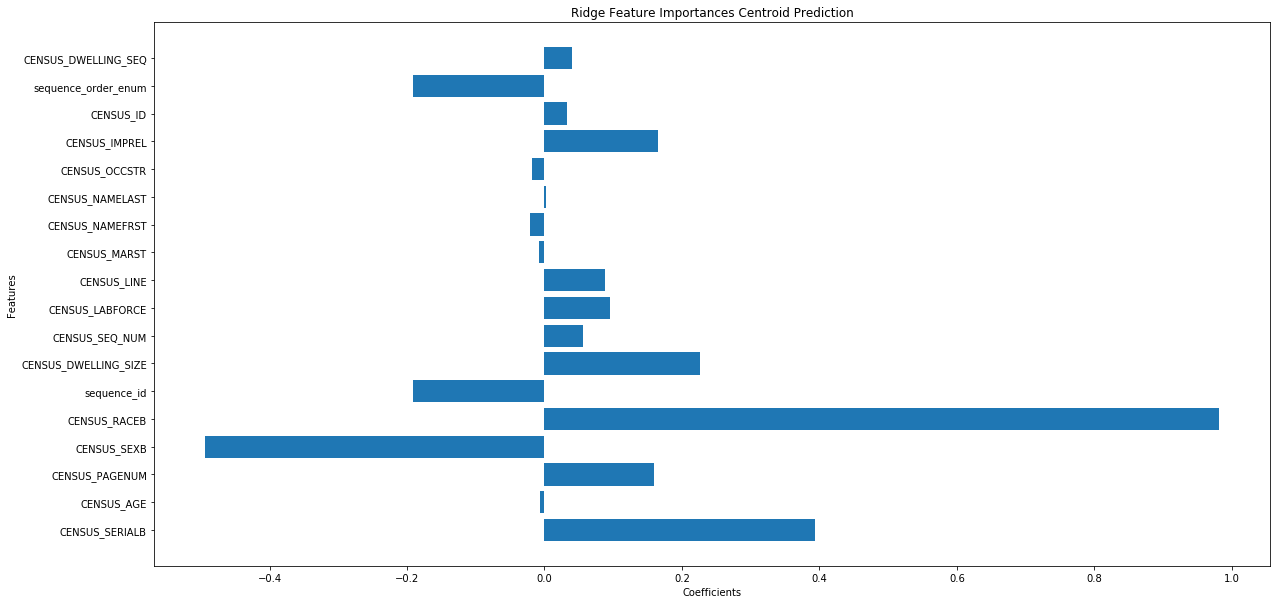

In [55]:
archive.graph_coefs(centroid_ridge_interpolator.model.named_steps["preprocess"].get_feature_names(), centroid_ridge_interpolator.model.named_steps["classifier"].coef_[4], "Ridge Feature Importances Centroid Prediction")

It's interesting to note that the feature importances change drastically between classes.

#### Gradient Boosting

In [29]:
boost_interpolator = CentroidInterpolator(census_data, 10, block_boost, all_cols, AgglomerativeClustering(5), block_centroids)

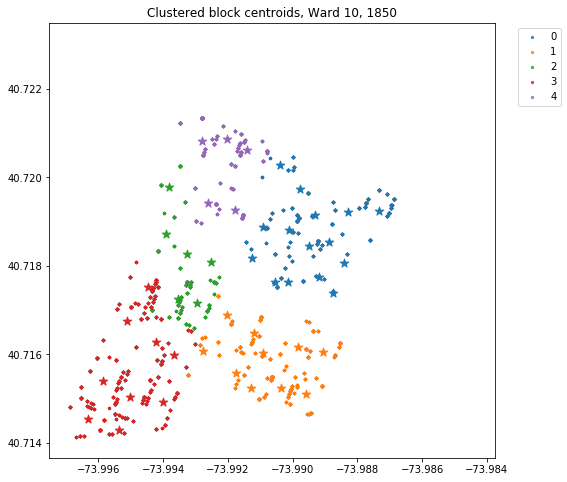

In [30]:
boost_interpolator.apply_clustering()
boost_interpolator.clustervis()

In [31]:
train,test = boost_interpolator.stratified_train_test()
boost_interpolator.train_test_model(train, test)

In [32]:
print("Training Score:", boost_interpolator.train_score)
print("Test Score:", boost_interpolator.test_score)

Training Score: 1.0
Test Score: 0.26916802610114193


In [33]:
test_results = test.copy()
test_results["predicted"] = boost_interpolator.predict(test)
display(interpolation.class_analysis(test_results, "cluster"))

Success rate: 0.26916802610114193
Failure rate: 0.7308319738988581


,record count,actual proportion,predicted proportion,predicted correctly,predicted incorrectly,proportion of class predicted correctly,proportion of class predicted incorrectly
0,361,0.196302,0.172920,0.191919,0.197917,0.263158,0.736842
1,416,0.226210,0.173464,0.167677,0.247768,0.199519,0.800481
2,173,0.094073,0.350734,0.107071,0.089286,0.306358,0.693642
3,670,0.364328,0.135400,0.262626,0.401786,0.194030,0.805970
4,219,0.119086,0.167482,0.270707,0.063244,0.611872,0.388128


Wit 6 clusters boosting worked better than ridge, but with 5 ridge worked better. So this isn't conclusive. Another aspect is tuning xgboost. This can definitely improve the results, but is quite expensive, and not reasonable to do for every possible variant of clustering algorithm.

### Feature Importances Investigation

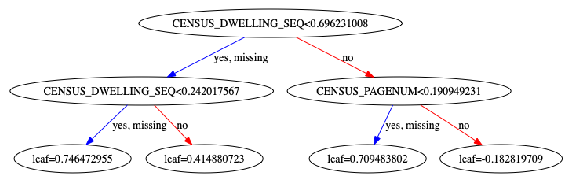

In [34]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_tree(boost_interpolator.model.named_steps["classifier"], num_tree = 10, ax = ax)
plt.show()

#### What would happen if I removed CENSUS_DWELLING_SEQ?

In [35]:
boost_model = XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 80)

In [36]:
no_dwell_seq = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID", "sequence_order_enum"]
boost_interpolator.set_features(no_dwell_seq)

In [37]:
boost_interpolator.set_model(boost_model)
train_X, test_X, train_y, test_y = boost_interpolator.target_encoder(train, test)
boost_interpolator.train_test_model(train_X, test_X, train_y, test_y)
print("Training Score:", boost_interpolator.train_score)
print("Test Score:", boost_interpolator.test_score)

Training Score: 1.0
Test Score: 0.2528548123980424


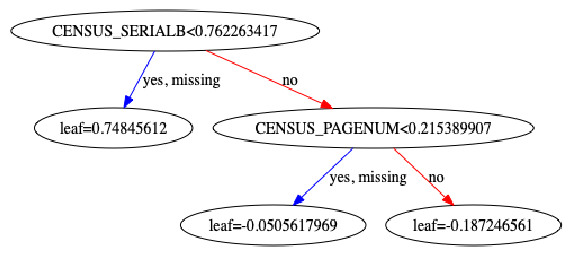

In [38]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_tree(boost_interpolator.model, tree_num = 15, ax = ax)

#### What about with no demographic information?

In [39]:
no_demo = ["CENSUS_SERIALB", "CENSUS_PAGENUM", "sequence_id", "CENSUS_OCCSTR", "sequence_order_enum", 'CENSUS_DWELLING_SEQ']
boost_interpolator.set_features(no_demo)
train_X, test_X, train_y, test_y = boost_interpolator.target_encoder(train, test)
boost_interpolator.train_test_model(train_X, test_X, train_y, test_y)
print("Training Score:", boost_interpolator.train_score)
print("Test Score:", boost_interpolator.test_score)

Training Score: 1.0
Test Score: 0.367047308319739


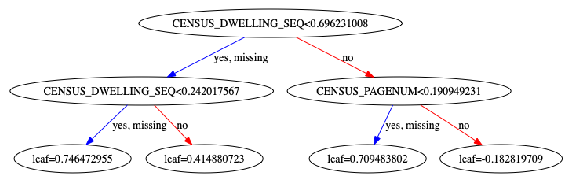

In [40]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_tree(boost_interpolator.model, tree_num = 15, ax = ax)

#### Without demographic information and without CENSUS_DWELLING_SEQ

In [41]:
no_demo_no_seq = ["CENSUS_SERIALB", "CENSUS_PAGENUM", "sequence_id", "CENSUS_OCCSTR", "sequence_order_enum"]
boost_interpolator.set_features(no_demo_no_seq)
train_X, test_X, train_y, test_y = boost_interpolator.target_encoder(train, test)
boost_interpolator.train_test_model(train_X, test_X, train_y, test_y)
print("Training Score:", boost_interpolator.train_score)
print("Test Score:", boost_interpolator.test_score)

Training Score: 1.0
Test Score: 0.34910277324632955


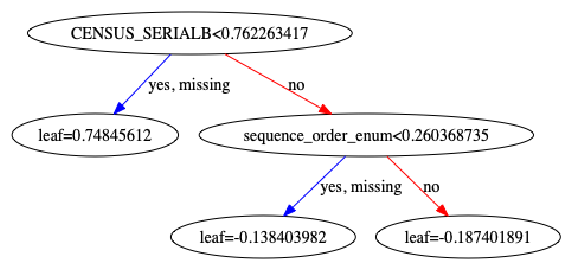

In [42]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_tree(boost_interpolator.model, tree_num = 60, ax = ax)
plt.show()

Including all possible features clearly helps the model, but the trees are positive indications because they suggest the model is using enumeration patterns

### Clustering Algorithm Selection

There are several possible clustering algorithms that could make sense for this process. Factors to consider:
- how many clusters are created?
    - the more clusters we can predict accurately, the more geographic specificity is added
- how accurately can the boosting model predict the results
- how geographically relevant are the results?
    - ei: clustering that involves noise may not be ideal, because the model will treat this as just another category and records labelled this way won't be understand as well

#### Kmeans

In [59]:
kmeans_interpolator = CentroidInterpolator(census_data, 10, boost_model, all_cols, KMeans(5), block_centroids)

In [62]:
#This is really unstable, need to use kmeans_best
for n in (4, 5, 6, 7, 8):
    print("{} clusters".format(n))
    algo = KMeans(n)
    kmeans_interpolator.clustering_algo_tuning(algo, clustervis= False)
    print("Training Score:", kmeans_interpolator.train_score)
    print("Test Score:", kmeans_interpolator.test_score)
    print("\n")

4 clusters
Training Score: 1.0
Test Score: 0.44458518049398354


5 clusters
Training Score: 1.0
Test Score: 0.24830316742081449


6 clusters
Training Score: 1.0
Test Score: 0.2701774470520893


7 clusters
Training Score: 1.0
Test Score: 0.309452736318408


8 clusters
Training Score: 1.0
Test Score: 0.29399255715045186




In [71]:
kmeans_interpolator.set_model(block_boost)
kmeans_results = {n:kmeans_interpolator.kmeans_best(n) for n in (4,5,6,7,8)}

n is 4 and it's the 0th iteration
n is 4 and it's the 50th iteration
n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration
n is 6 and it's the 0th iteration
n is 6 and it's the 50th iteration
n is 7 and it's the 0th iteration
n is 7 and it's the 50th iteration
n is 8 and it's the 0th iteration
n is 8 and it's the 50th iteration


In [72]:
kmeans_scores = pd.DataFrame({key:value[0] for key, value in kmeans_results.items()}, index=["Best Score"]).T.rename_axis("Number of Clusters").reset_index()
display(kmeans_scores)

,Number of Clusters,Best Score
0,4,0.561668
1,5,0.471264
2,6,0.458716
3,7,0.392015
4,8,0.393434


Kmeans results can be quite unstable. Taking the best of 100 runs seems to provide a reasonable amount of consistancy, but 

#### Agglomerative Clustering

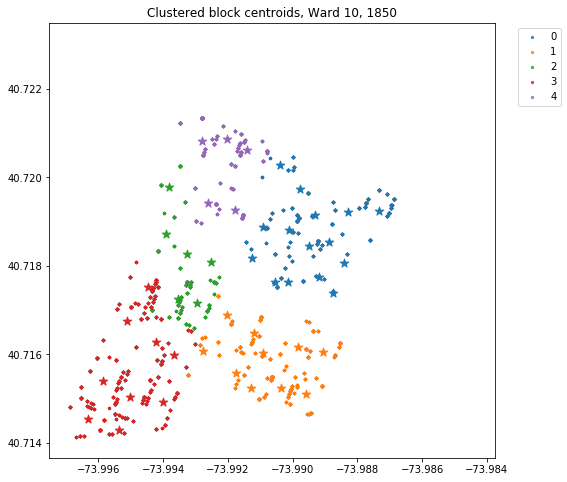

In [81]:
agg_interpolator = CentroidInterpolator(census_data, 10, block_boost, all_cols, AgglomerativeClustering(5), block_centroids)
agg_interpolator.apply_clustering()
agg_interpolator.clustervis()

**Evaluate:** Geographic Specificity 
This seems like it would work well for predicting geographically specific areas

In [82]:
train,test = agg_interpolator.stratified_train_test(stratified = True)
agg_interpolator.train_test_model(train, test)
print("Training Score:", agg_interpolator.train_score)
print("Test Score:", agg_interpolator.test_score)

Training Score: 1.0
Test Score: 0.26916802610114193


In [96]:
agglomerative_results = {}
for n in (4,5,6,7,8):
    algo = AgglomerativeClustering(n)
    agg_interpolator.clustering_algo_tuning(algo, clustervis= False)
    agglomerative_results[n] = agg_interpolator.test_score

This is  stable over reruns in comparison with kmeans

#### DBScan

In [84]:
db_interpolator = CentroidInterpolator(census_data, 10, block_boost, all_cols, DBSCAN(), block_centroids)

0.0011


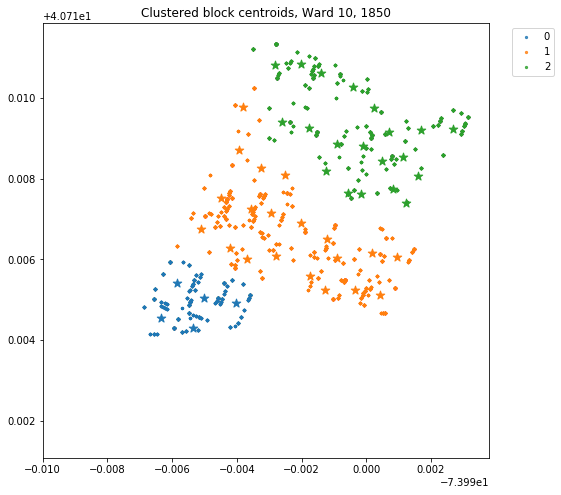

Test Score: 0.5009970089730807
0.001


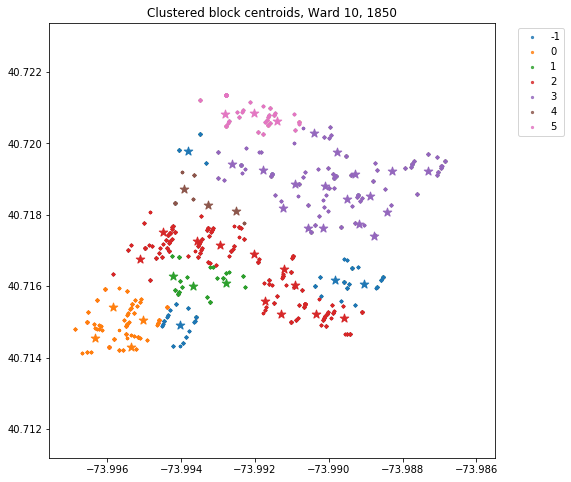

Test Score: 0.4162826420890937
0.00101


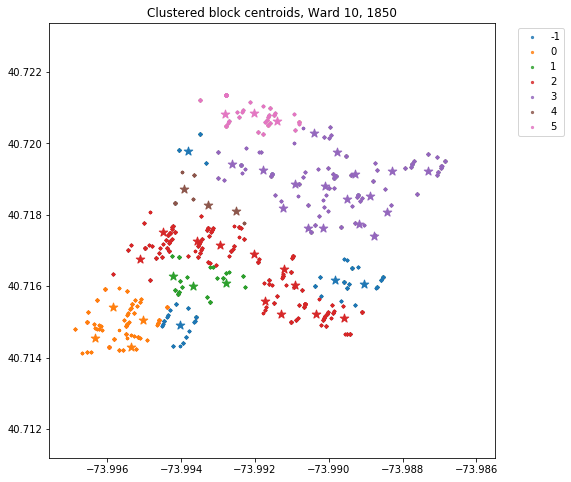

Test Score: 0.4162826420890937
0.0009


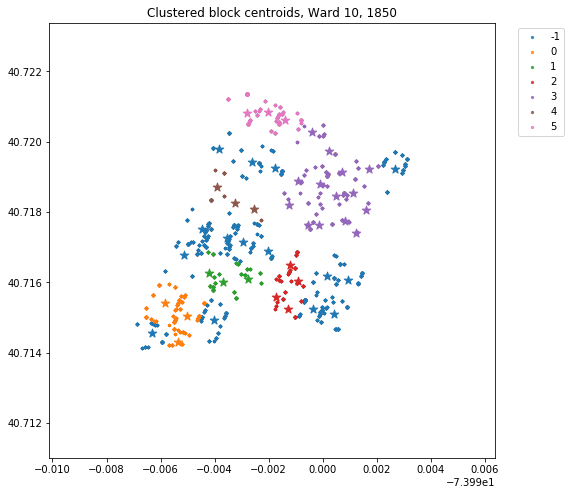

Test Score: 0.49390243902439024


In [88]:
dbscan_results = {}
eps_ops = [0.0011, 0.001, 0.00101, 0.0009]
for n in eps_ops:
    print(n)
    algo = DBSCAN(eps = n,min_samples = 3)
    db_interpolator.clustering_algo_tuning(algo)
    dbscan_results[len(np.unique(db_interpolator.clusters))] = db_interpolator.test_score
    print("Test Score:", db_interpolator.test_score)

This is stable, unlike kmeans, but deciding what works needs to be done carefully, since the noise label is treated like another cluster but can be spread out accross geographies, so may not help with answering the geographic specificity question.

#### hdbscan

In [91]:
hdb_interpolator = CentroidInterpolator(census_data, 10, block_boost, all_cols, hdbscan.HDBSCAN(), block_centroids)

min_samples: 2


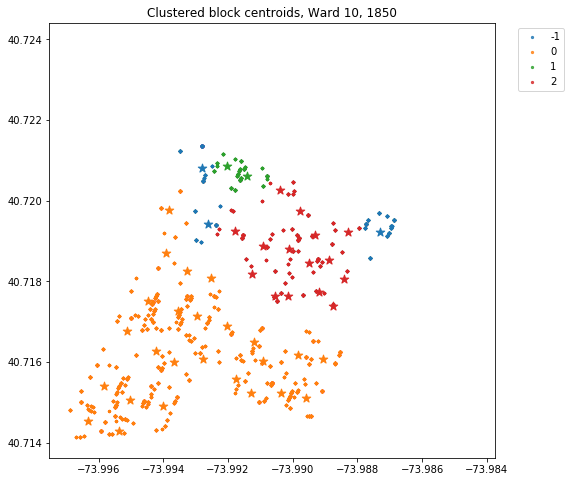

0.6871852266368215
min_samples: 3


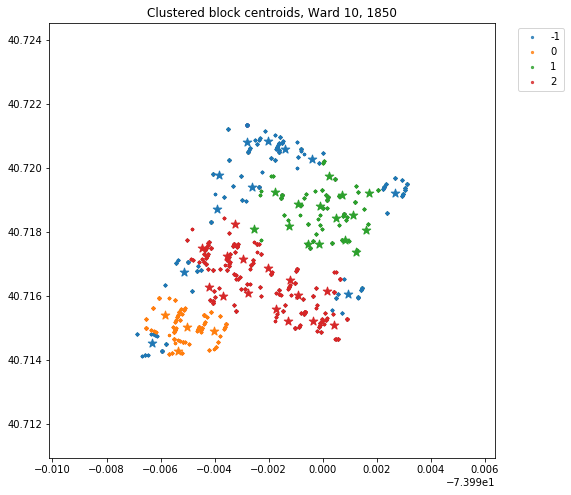

0.28150134048257375
min_samples: 4


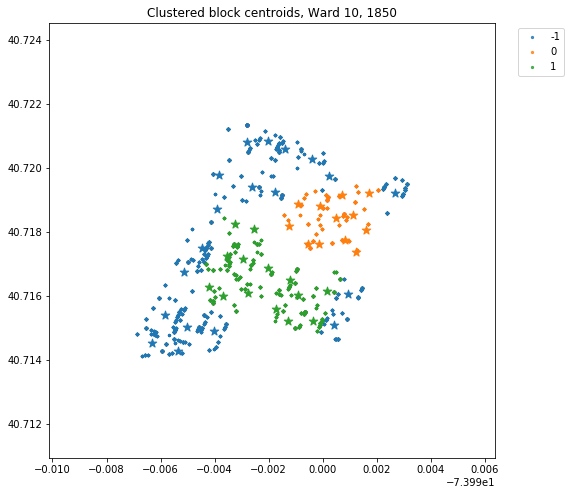

0.5442908346134152
min_samples: 5


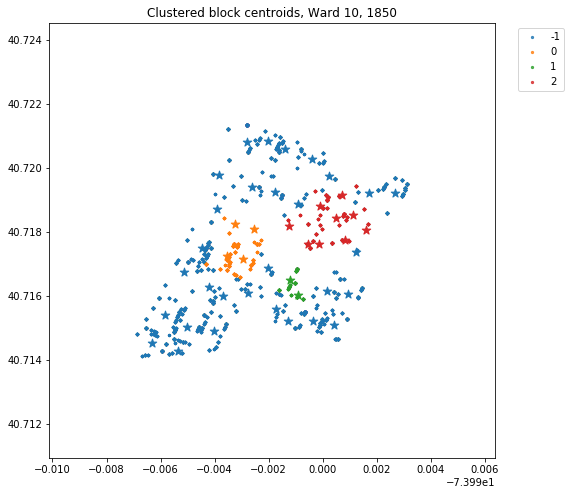

0.6966133584195673


In [92]:
hdb_results = {}
for n in (2,3,4,5):
    print("min_samples:", n)
    algo = hdbscan.HDBSCAN(min_cluster_size=2, min_samples = n)
    hdb_interpolator.clustering_algo_tuning(algo)
    print(hdb_interpolator.test_score)
    hdb_results[len(np.unique(hdb_interpolator.clusters))] = hdb_interpolator.test_score
    

It doesn't seem that this would work well for our purpose since in cases when it performs well it doesn't seem to add much geographic specificity, but it does get fairly high scores in some cases, and depending on how few clusters we're willing to use and consider useful, it perhaps has some potential

#### Cluster algorithms results summary

In [98]:
all_clust_results = [{key:value[0] for key, value in kmeans_results.items()}, agglomerative_results, dbscan_results, hdb_results]
pd.DataFrame(all_clust_results, index = ["Kmeans", "Agglomerative", "dbscan", "hdb"]).T.sort_index()

,Kmeans,Agglomerative,dbscan,hdb
3,NaN,NaN,0.500997,0.544291
4,0.561668,0.506862,NaN,0.696613
5,0.471264,0.269168,NaN,NaN
6,0.458716,0.400993,NaN,NaN
7,0.392015,0.323158,0.493902,NaN
8,0.393434,0.333162,NaN,NaN


### Tune XGBoost Model

Further experiments:
- tune xgboosting model